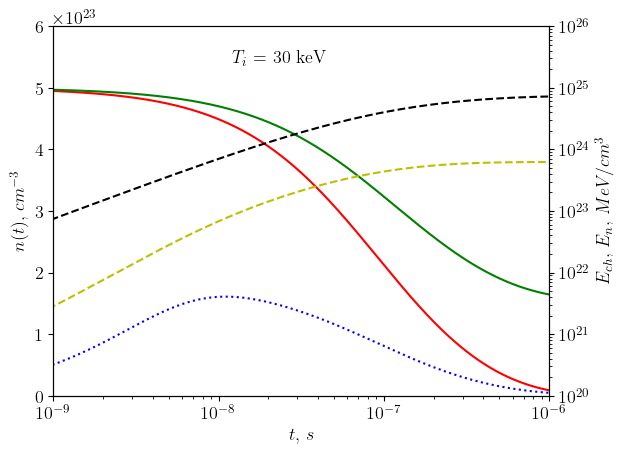

0.6036491394042969 sec


In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotx
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})
rc('text', usetex=True)
import time

####reactivity parametrization of DT, D3He, DDp, DDn reactions
def react(T, channel):
    if channel == 'tt':
        return 5.41*1e-14*T**(-2/3)*np.exp(-21.52/T**(1/3))
    elif channel == '3he3he':
        return 1.93*1e-12*T**(-2/3)*np.exp(-54.22/T**(1/3))
    else:
        if channel == 'dt':
            ksi =  np.array([-42.559, 33.312, -9.876,  2.501, -0.414, 0.0,   0.0])
            neta = np.array([0.0,     24.394, -16.909, 7.406, -2.148, 0.411, 0.0])
        if channel == 'd3he':
            ksi =  np.array([-60.504, 53.039, -16.233, 3.980, -0.749, 0.0, 0.004])
            neta = np.array([0.0,     43.244, -31.497, 15.707, -6.055, 1.734, -0.319])
        if channel == 'ddp':
            ksi =  np.array([-41.898, 30.017, -9.150,  2.140, -0.316, 0.0,   0.012])
            neta = np.array([0.0,     24.313, -16.995, 7.572, -2.540, 0.580, -0.068])
        if channel == 'ddn':
            ksi =  np.array([-42.145, 30.484, -9.451,  2.265, -0.346, 0.0,   0.015])
            neta = np.array([0.0,     24.459, -17.170, 7.744, -2.655, 0.630, -0.079])
        t = (np.pi/5.30)*(np.log10(T*1000) -3.65)
        s = sum(ksi[k]*np.cos(k*t)+neta[k]*np.sin(k*t) for k in range(len(ksi)))
        return np.power(10, s)
###################################################################

start = time.time()
T = 30  ### initial temperature T = 10 KeV
def F(s,t_int):
    
    # Fusion reaction rates
    r_dd_p = react(s[0],'ddp') 
    r_dd_n = react(s[0],'ddn') 
    r_dt =   react(s[0],'dt')
    r_d3he = react(s[0],'d3he')    
    r_dd =   react(s[0],'ddp') + react(s[0],'ddn')
    r_tt =   react(s[0],'tt')
    r_3he3he=react(s[0],'3he3he')
    
    # Q values and energies for fusion reactions in MeV
    Q_ddp = 4.03; Q_ddn = 3.27; Q_d3he = 18.35;
    E_ddn = 0.82; E_adt = 3.52; E_n1 = 2.45;   E_n2 = 14.07;
    E_att = 3.7766 ; Q3he3he = 12.86; En34 = (2/3)*11.33
    
    
    # D, T and 3He densities in cm^-3
    nd   = -0.5*r_dd   * s[1]*s[1] - r_dt  *s[1]*s[2] -r_d3he*s[1]*s[3]
    nt   = +0.5*r_dd_p * s[1]*s[1] - r_dt  *s[1]*s[2] - 0.5*r_tt*s[2]*s[2]
    n3he = +0.5*r_dd_n * s[1]*s[1] - r_d3he*s[1]*s[3] - 0.5*r_3he3he*s[3]*s[3]
    #na   =       r_dt  *s[1]*s[2]  + 0.5*r_3he3he*s[3]*s[3] + 0.5*r_tt*s[2]*s[2]
    # Energy yield in keV/cm^3 for charged particles
    Ech =  (0.5*r_dd_p * s[1]*s[1]* Q_ddp + r_dt  * s[1]*s[2]* E_adt+
            0.5*r_dd_n * s[1]*s[1]* E_ddn + r_d3he* s[1]*s[3]* Q_d3he+
            0.5*r_3he3he*s[3]*s[3]*Q3he3he + 0.5*r_tt*s[2]*s[2]*E_att)
    
    # Energy yield in keV/cm^3 for Neutrons
    En =    (0.5*r_dd_n * s[1]*s[1]* E_n1 +  r_dt * s[1]*s[2]* E_n2 +
             0.5*r_tt*s[2]*s[2]*En34)
    
    
    ne = s[1]+s[2]+2*s[3] # Electron density in cm^-3, assuming const
    ###Bremsstrahlung power radiation losses in kev/cm^3
    Pbr = 0.334e-17*np.sqrt(s[0])*(s[1]+s[2]+4*s[3])*ne
    
    ### Temperature in keV
    T = 0
    return [T, nd, nt, n3he, Ech, En]

t_int = np.linspace(1e-12,1.03e-6, 100000)
#initial concentrations n_d,n_t,n_3he and energies Ech, En
n0=[30,5e+23,1e+10,5e+23, 1e+10, 1e+10] 
sol = odeint(F,n0,t_int)

fig, ax1 = plt.subplots()
ax1.plot(t_int,sol[:,1],'r-', linewidth=1.5)
ax1.plot(t_int,100*sol[:,2],'b:', linewidth=1.5)
ax1.plot(t_int,sol[:,3],'g-', linewidth=1.5)
ax1.set(ylim=[0, 6e+23])
ax1.set(xlim=[1e-9,1e-6], xscale='log')
ax1.set_ylabel('$n(t)$, $cm^{-3}$', loc='center')
plt.xlabel('$t$, $s$')
ax2 = ax1.twinx()
ax2.plot(t_int,sol[:,4],'k--', linewidth=1.5)
ax2.plot(t_int,sol[:,5],'y--', linewidth=1.5)
ax2.set(ylim = [1e+20, 1e+26], yscale = 'log')

ax2.set_ylabel('$E_{ch}$, $E_{n}$, $MeV/cm^{3}$', loc = 'center')

###labels for lines 
ax1.text(1.2e-8, 5.4e+23,'$T_{i}$ = '+str(T)+' keV')
#ax1.text(3e-7, 5.2e+23,'$^{3}He$')
#ax1.text(6e-8, 4.4e+23,'$D$')
#ax1.text(6e-8, 0.7e+23,'$T\cdot 10^{2}$')
#ax1.text(1e-8, 3.1e+23,'$E_{ch}$')
#ax1.text(3e-8, 2.4e+23,'$E_{n}$')
#plt.savefig('DTfuel_burn.jpg', dpi= 1000,bbox_inches='tight')
plt.show()
end = time.time() - start
print(end,'sec')

In [2]:
Evor = np.array(sol[:,4])
with open('file1.txt', 'w') as f:
    f.writelines(f"{item}\n" for item in Evor)

In [3]:
Envor = np.array(sol[:,5])
with open('file2.txt', 'w') as f:
    f.writelines(f"{item}\n" for item in Envor)